In [1]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C:\Users\ricca\AppData\Local\Temp\ipykernel_12092\4233083143.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [3]:
data = pd.read_csv(parent+r'\RES3.txt', sep='\t')

In [4]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [5]:
F = data['F']
I = data['I']
Q = data['Q']

In [6]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

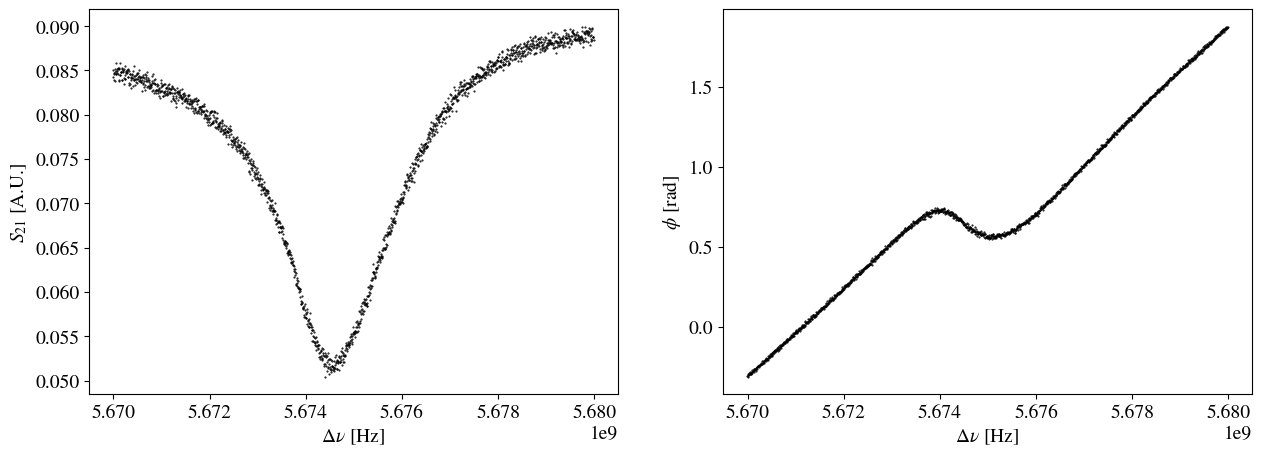

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [8]:
A = 20*np.log10(np.sqrt(A))
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [9]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [10]:
p0 = [1e-20,1e-15,-10.7,2e3,8e3,3.2,5.6745*1e9]

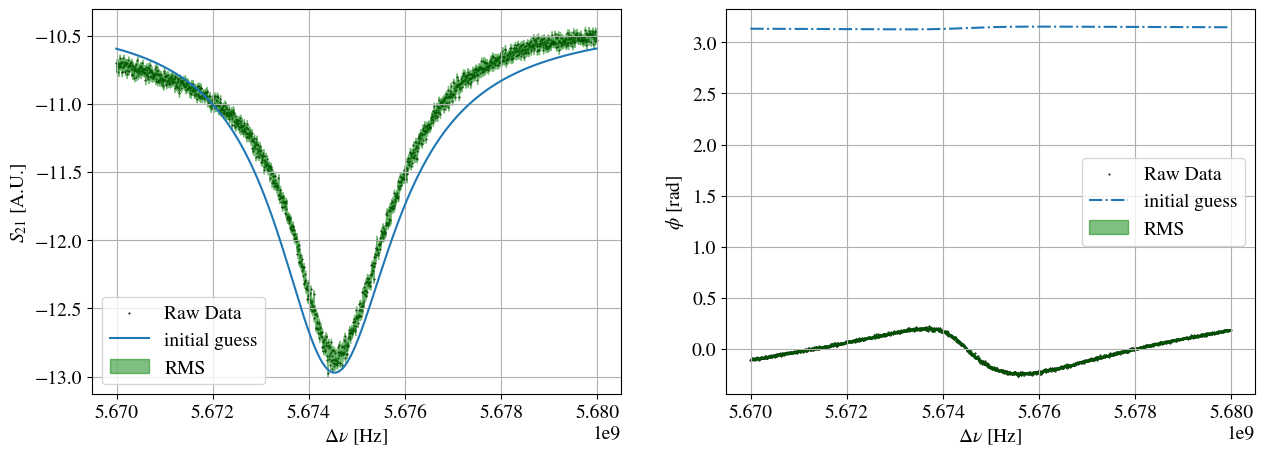

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [12]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4153 (χ²/ndof = 2.6)       │              Nfcn = 220              │
│ EDM = 0.000155 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 9.100e-21 │ 0.033e-21 │            │            │         │         │       │
│ 1 │ x1   │ -5.13e-12 │ 0.13e-12  │            │            │         │         │       │
│ 2 │ x2   │ -10.7293  │  0.0010   │            │            │         │         │       │
│ 3 │ x3   │  2.409e3  │  0.005e3  │            │            │         │         │       │
│ 4 │ x4   │ 10.636e3  │  0.025e3  │            │            │         │         │       │
│ 5 │ x5   │  3.0294   │  0.0015   │            │            │         │         │       │
│ 6 │ x6   │5.674691e9 │0.000002e9 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                              x0                              x1                              x2                              x3                              x4                              x5                              x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                        1.06e-45                1.1225728876e-36      -8.8318872651641235905e-27  -58.8275532121326847345699e-24 -506.3866152435996355052339e-24      -1.1592712835184655340e-27  419.3669773608749551385699e-24 │
│ x1 │                1.1225728876e-36                        1.75e-26                21.540899654e-18           -367.554326520212e-15          -2.158462302393037e-12                27.161245302e-18         -21.859390185222118e-12 │
│ x2 │      -8.8318872651641235905e-27                21.540899654e-18                        9.29e-07                      -2.2772e-3                      -8.1903e-3                          0.3e-6                    -261.6052e-3 │
│ x3 │  -58.8275532121326847345699e-24           -367.554326520212e-15                      -2.2772e-3                            26.2                             112                       -458.0e-6                              93 │
│ x4 │ -506.3866152435996355052339e-24          -2.158462302393037e-12                      -8.1903e-3                             112                             614                      -4.1091e-3                           2.5e3 │
│ x5 │      -1.1592712835184655340e-27                27.161245302e-18                          0.3e-6                       -458.0e-6                      -4.1091e-3                        2.31e-06                      -2.

In [13]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.901e+05 (χ²/ndof = 244.7)│             Nfcn = 39288             │
│ EDM = 6.77e+12 (Goal: 0.0002)    │           time = 13.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.4e-18  │  1.8e-18  │            │            │         │         │       │
│ 1 │ x1   │-59.54e-12 │ 0.29e-12  │            │            │         │         │       │
│ 2 │ x2   │ -13.2986  │  0.0018   │            │            │         │         │       │
│ 3 │ x3   │  6.367e3  │  0.015e3  │            │            │         │         │       │
│ 4 │ x4   │  127.2e3  │   1.6e3   │            │            │         │         │       │
│ 5 │ x5   │  2.8494   │  0.0026   │            │            │         │         │       │
│ 6 │ x6   │5.6747215e9│0.0000021e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                       x0                       x1                       x2                       x3                       x4                       x5                       x6 │
├────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                 3.19e-36                104.6e-36      -566.3000943520e-27     61.7117829714771e-24 -26.8597798297296464e-21      -306.2838856397e-27 347.3815665955348209e-21 │
│ x1 │                104.6e-36                 8.56e-26        -376.08059052e-18      142.26606013889e-15  -124.17442346059185e-12          88.92492088e-18   -70.10586369469885e-12 │
│ x2 │      -566.3000943520e-27        -376.08059052e-18                 3.33e-06                1.5886e-3               -1.3678661                   1.0e-6             -801.8466e-3 │
│ x3 │     61.7117829714771e-24      142.26606013889e-15                1.5886e-3                      238                  -0.58e3                 7.057e-3                  -6.32e3 │
│ x4 │ -26.8597798297296464e-21  -124.17442346059185e-12               -1.3678661                  -0.58e3                 2.43e+06                -1.691874                    1.3e6 │
│ x5 │      -306.2838856397e-27          88.92492088e-18                   1.0e-6                 7.057e-3                -1.691874                 6.49e-06                -4.407674 │
│ x6 │ 347.3815665955348209e-21   -70.10586369469885e-12             -801.8466e-3                  -6.32e3                    1.3e6                -4.407674                 4.31e+06 │
└────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

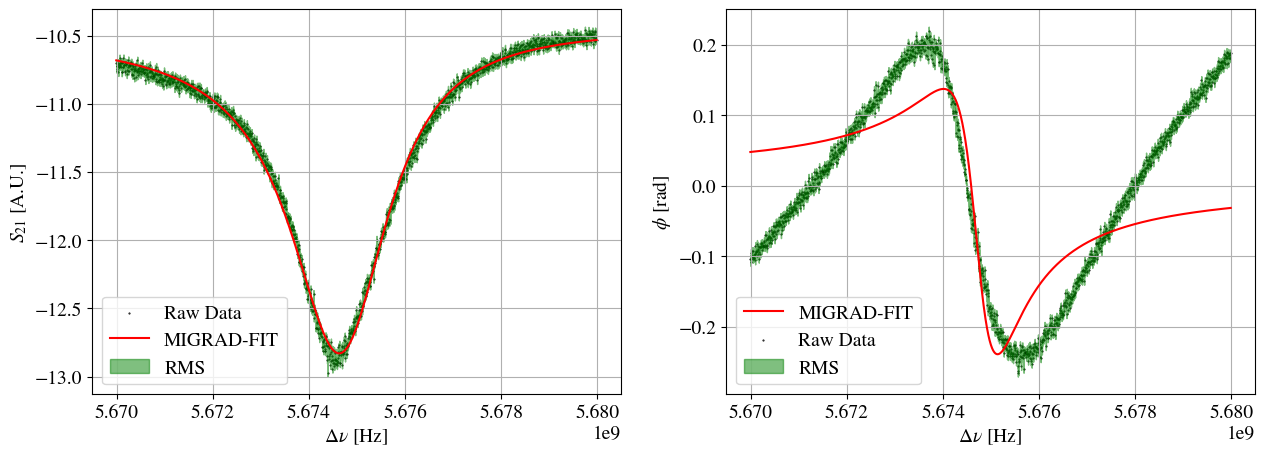

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

Text(5670000000.0, -12, '$\\chi^{2}_{0} = $2.61')

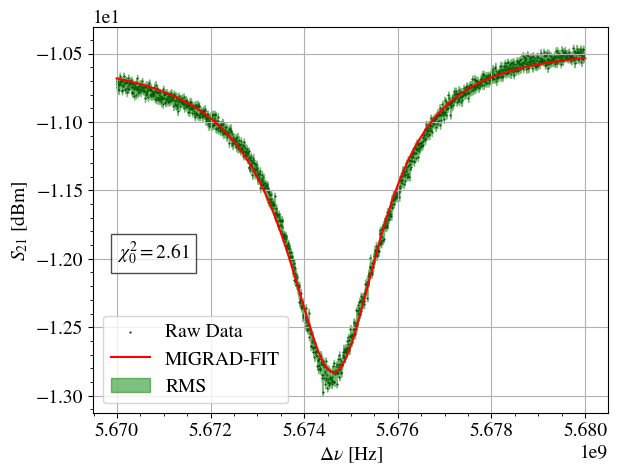

In [17]:
fig, axs = plt.subplots(1,1)
axs.scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs.plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs.set_xlabel(r'$\Delta \nu$ [Hz]')
axs.set_ylabel(r'$S_{21}$ [dBm]')
axs.fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs.legend()
axs.minorticks_on()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# Place the combined text with a bounding box
axs.text(5.670*1e9,-12,r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}",
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

In [29]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  2409.0872181396194
Q(phase) =  6367.078844887413
Q_c(S21) =  10635.736484925903
Q_c(phase) =  127985.49299800085


In [30]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  1964.1826830756595
